# Importazione Librerie

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import os

# Caricamento Dataset e pre-processing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
path = os.getcwd()
path_dataset = 'drive/MyDrive/Colab Notebooks/Datasets'

path_ = os.path.join(path, path_dataset, 'diabetes.csv')
data = pd.read_csv(path_)

# stampiamo le prime 10 righe del dataset per capire la struttura
data.head(10)

gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   
5  Female  20.0             0              0           never  27.32   
6  Female  44.0             0              0           never  19.31   
7  Female  79.0             0              0         No Info  23.86   
8    Male  42.0             0              0           never  33.64   
9  Female  32.0             0              0           never  27.32   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
5          6.6                   85         0  
6          6.5                  200         1  
7          5.7                   85         0  
8          4.8                  145         0  
9          5.0                  100         0

In [48]:
# one hot encoding per la feature smoking_history
data_smoking = pd.get_dummies(data['smoking_history'])

# usiamo come riferimento persone che non hanno mai fumato (la presenza della colonna si determina dall'assenza di altre colonne)
# "ever" è un errore di battitura
data_smoking = data_smoking.drop(columns=['never', 'ever'])

# one hot encoding per la feature gender
data_gender = pd.get_dummies(data['gender'])

# usiamo come riferimento persone di sesso maschie
data_gender = data_gender.drop(columns=['Male'])

# eliminiamo dal dataframe le colonne originali di smoking_history e gender, e aggiungiamo le versioni codificate
data = pd.concat([data.drop(columns=['smoking_history', 'gender']), data_gender, data_smoking], axis=1)

# eliminiamo dal dateset le persone (righe) con gender other per la scarsa rappresentatività
data = data[data.Other != 1]

# eliminiamo dal dataset le feature (colonne) relative alla smoking history no info e not currente, e relative a gender other
data = data.drop(columns=['No Info', 'not current', 'Other'])

In [49]:
data

age  hypertension  heart_disease    bmi  HbA1c_level  \
0      80.0             0              1  25.19          6.6   
1      54.0             0              0  27.32          6.6   
2      28.0             0              0  27.32          5.7   
3      36.0             0              0  23.45          5.0   
4      76.0             1              1  20.14          4.8   
...     ...           ...            ...    ...          ...   
99995  80.0             0              0  27.32          6.2   
99996   2.0             0              0  17.37          6.5   
99997  66.0             0              0  27.83          5.7   
99998  24.0             0              0  35.42          4.0   
99999  57.0             0              0  22.43          6.6   

       blood_glucose_level  diabetes  Female  current  former  
0                      140         0    True    False   False  
1                       80         0    True    False   False  
2                      158         0   False    False   False  
3                      155         0    True     True   False  
4                      155         0   False     True   False  
...                    ...       ...     ...      ...     ...  
99995                   90         0    True    False   False  
99996                  100         0    True    False   False  
99997                  155         0   False    False    True  
99998                  100         0    True    False   False  
99999                   90         0    True     True   False  

[99982 rows x 10 columns]

In [50]:
# stampiamo le informazioni generali
print(data.info())

print('Are there any null values?: ', data.isnull().values.any())
print('Are there duplicate values?: ', data.duplicated())
print('Sum of null values: ', data.isnull().sum())
print('Sum of duplicated values :', data.duplicated().sum())

# stampiamo le statistiche descrittive
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 99982 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  99982 non-null  float64
 1   hypertension         99982 non-null  int64  
 2   heart_disease        99982 non-null  int64  
 3   bmi                  99982 non-null  float64
 4   HbA1c_level          99982 non-null  float64
 5   blood_glucose_level  99982 non-null  int64  
 6   diabetes             99982 non-null  int64  
 7   Female               99982 non-null  bool   
 8   current              99982 non-null  bool   
 9   former               99982 non-null  bool   
dtypes: bool(3), float64(3), int64(4)
memory usage: 6.4 MB
None
Are there any null values?:  False
Are there duplicate values?:  0        False
1        False
2        False
3        False
4        False
         ...  
99995     True
99996    False
99997    False
99998    False
99999    False
Le

Osserviamo che, dalle statistiche descrittive, nel dataset l'individuo medio è in sovrappreso (bmi medio >25.0), molto vicino ad essere pre-diabetico e/o ha il diabete (livelli medi HbA1C < 5.7, dove livelli maggiori di 5.7 indicano il pre-diabete. livelli medi blood glucose > 126 mg/dL indicano diabete). Si noti che il dataset non menziona se i livelli di glicemia a digiuno (fasting blood sugar levels) siano o meno presenti. Tuttavia, i livelli di glicemia sono solitamente a digiuno, quindi presumiamo che sia così anche in questo caso. Variabili come ipertensione, malattie cardiache e diabete sono in realtà variabili categoriali, in quanto hanno valori pari a 0 e 1.

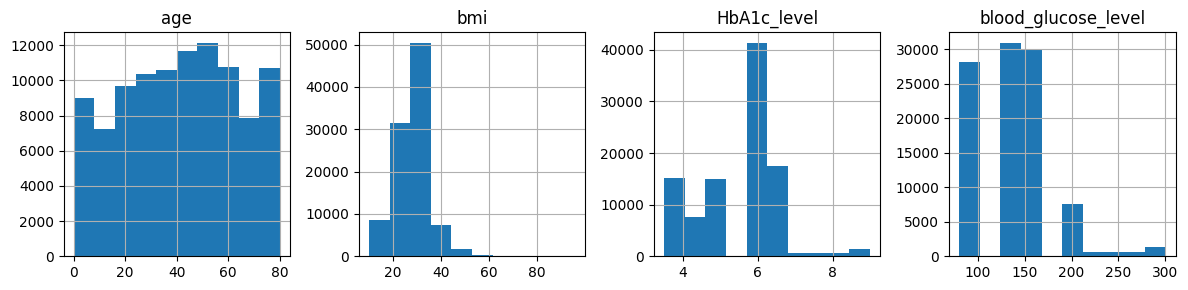

In [52]:
# plottiamo gli istogrammi delle feature continue per visualizzare a distribuzione

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

for i in range(4):
    data.hist(column=cols[i], ax=ax[i])

plt.tight_layout()
plt.show()

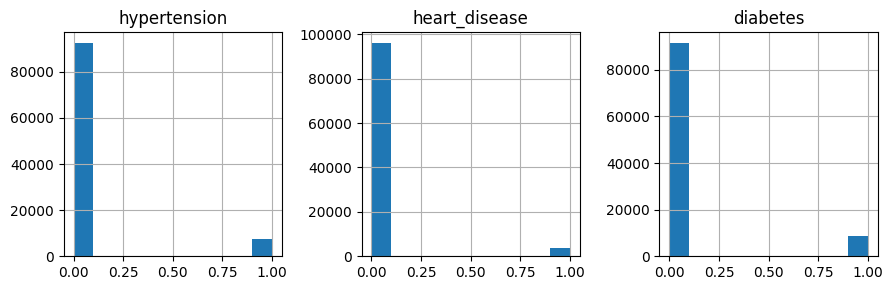

In [53]:
# plottiamo gli istogrammi delle feature categorighe per visualizzare a distribuzione

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
cols = ['hypertension', 'heart_disease', 'diabetes']

for i in range(3):
    data.hist(column=cols[i], ax=ax[i])

plt.tight_layout()
plt.show()

<Axes: >

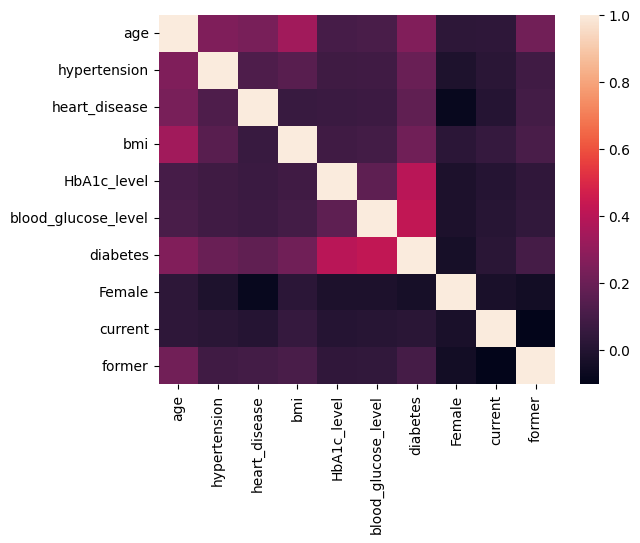

In [51]:
# correlation map (correlazione tra ogni coppia di feature)
sns.heatmap(data.corr())

Dall'heatmap, osserviamo che la correlazione più forte è tra diabetes e blood sugar levels e HvA1C levels, il che non sorprende. Il diabete è in qualche modo correlato a hypertension, heart disease , age e bmi, e non più di tanto a smoking history.

In [54]:
# dividiamo le features in features di input e feature target
X = data.drop(columns=['diabetes'])
y = data['diabetes']

# dividiamo il dataset in 66% di training e 33% di testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#**Decision Tree**

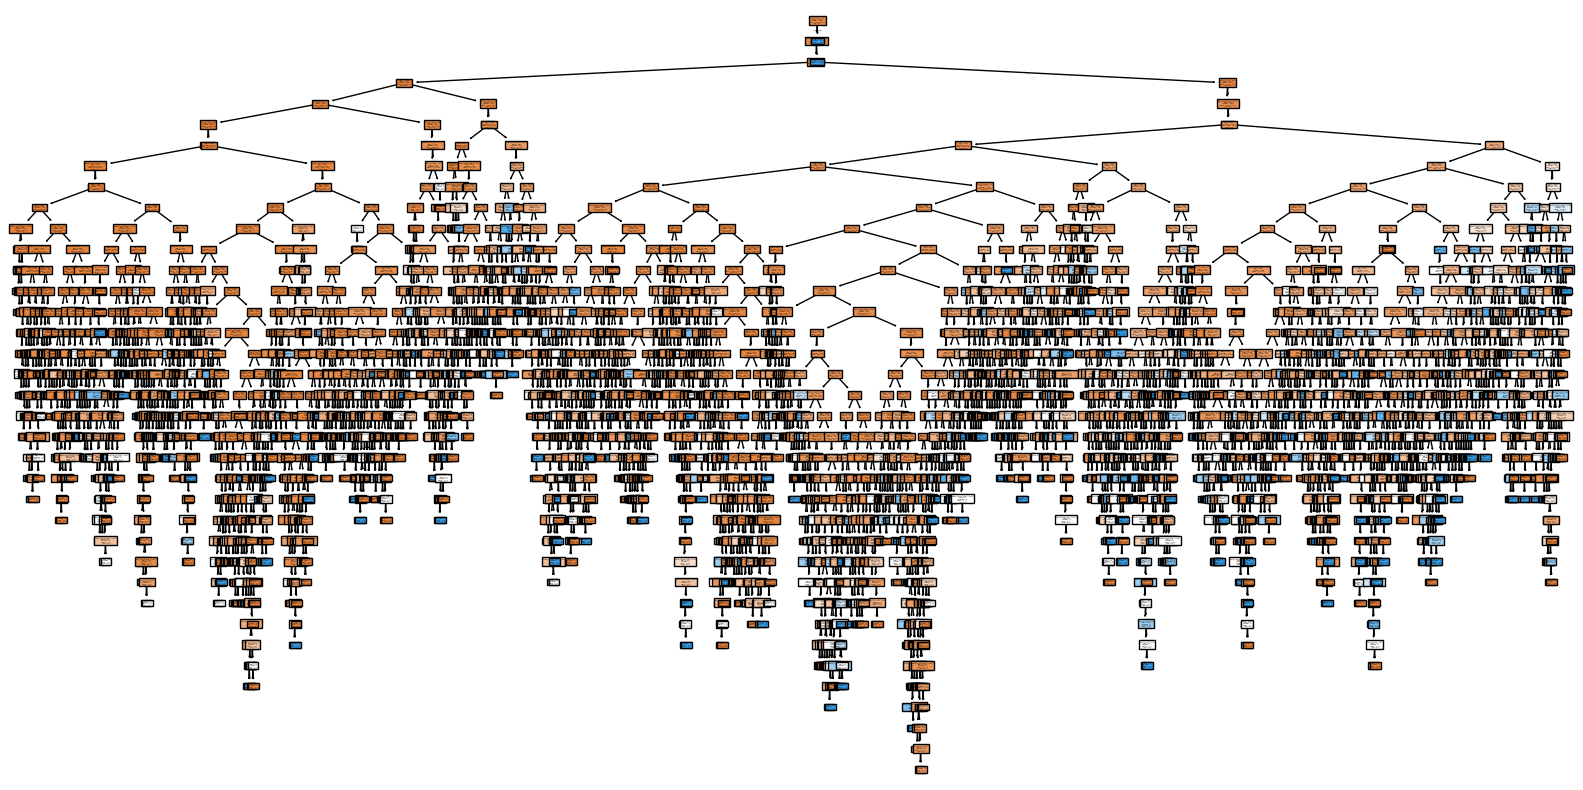

In [55]:
from sklearn import tree

# definiamo il modello Decision Treee
model = tree.DecisionTreeClassifier()

# addestriamo il modello
model.fit(X_train, y_train)

# stampiamo il decision tree appreso
plt.figure(figsize=(20, 10))
tree.plot_tree(model, filled=True, feature_names=X.columns, class_names=['No', 'Yes'])
plt.show()

In [ ]:
"""
Text(0.5175985438422946, 0.9864864864864865, 'x[4] <= 6.7\ngini = 0.154\nsamples = 66987\nvalue = [61352, 5635]') significa che :
- x[4] <= 6.7 :  La condizione usata per dividere i dati in quel nodo (la quinta feature è ≤ 6.7).
- gini = 0.154 : l’indice di Gini (una misura di impurità: 0 = puro, 0.5 = massimo disordine).
- samples = 66987 : Numero di campioni in quel nodo.
- value = [61352, 5635] : Quanti esempi appartengono a ciascuna classe (es. classe 0 = 61352, classe 1 = 5635).
"""

In [56]:
import graphviz

# stampiamo il decision tree appreso in modo che sia il grafico sia ingrandibile e leggibile

dot_data = tree.export_graphviz(model, out_file=None, feature_names= X_train.columns, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)

graph

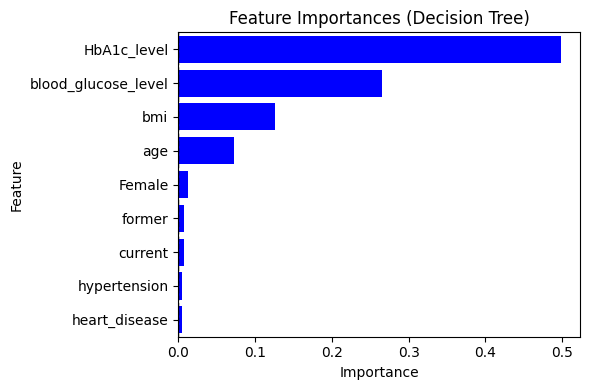

In [57]:
# calcoliamo l'importanza delle feature
importance = model.feature_importances_

coef_df = pd.DataFrame({'coef': importance, 'varname': X_train.columns})
coef_df = coef_df.sort_values(by='coef', ascending=False).iloc[::-1]

# plottiamo il grafico
coef_df.plot(y='coef', x='varname', kind='barh', color='none', legend=False, figsize=(6, 4))

plt.barh(coef_df['varname'], coef_df['coef'], color='blue')
plt.axvline(x=0, linestyle='--', color='black', linewidth=1)
plt.title("Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [59]:
# effettuiamo le predizioni per gli esempi di testing
y_pred = model.predict(X_test)

# calcoliamo l'accuracy del modello
print('Model accuracy: ', model.score(X_test, y_test)*100)

Model accuracy:  95.0810728898318


#**Decision Tree: Max-depth = 2**

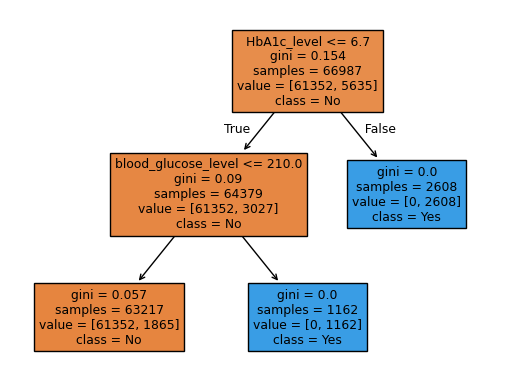

In [73]:
# definiamo il modello
model = tree.DecisionTreeClassifier(max_depth = 2)

# addestriamo il modello
model.fit(X_train, y_train)

# stampiamo il decision tree appreso
tree.plot_tree(model, filled=True, feature_names=X.columns, class_names=['No', 'Yes'])
plt.show()

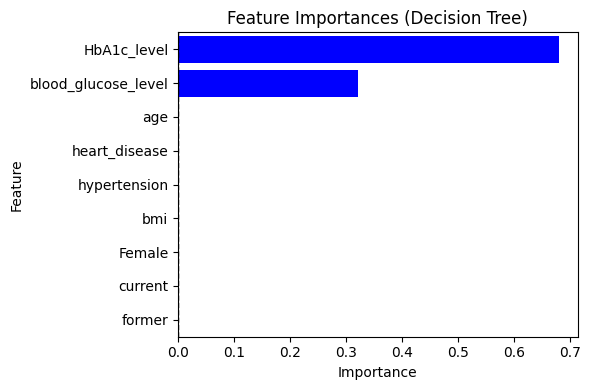

In [71]:
# calcoliamo l'importanza delle feature
importance = model.feature_importances_

coef_df = pd.DataFrame({'coef': importance, 'varname': X_train.columns})
coef_df = coef_df.sort_values(by='coef', ascending=False).iloc[::-1]

# plottiamo il grafico
coef_df.plot(y='coef', x='varname', kind='barh', color='none', legend=False, figsize=(6, 4))

plt.barh(coef_df['varname'], coef_df['coef'], color='blue')
plt.axvline(x=0, linestyle='--', color='black', linewidth=1)
plt.title("Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [72]:
# effettuiamo le predizioni per gli esempi di testing
y_pred = model.predict(X_test)

# calcoliamo l'accuracy del modello
print('Model accuracy: ', model.score(X_test, y_test)*100)

Model accuracy:  97.126837399606
